<img src='otus.png'>

# Метод опорных векторов (Support Vector Machine)

In [1]:
import time
import re
from __future__ import print_function
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

# Ансамбли

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Уравнение прямой задаётся как: $$g(x) = w_0 + w_1x_1 + w_2x_2 = w_0 + \langle w, x \rangle = w_0 +  w^\top x $$

* Если $g(x^*) > 0$, то $y^* = \text{'черный'} = +1$
* Если $g(x^*) < 0$, то $y^* = \text{'белый'} = -1$
* Если $g(x^*) = 0$, то мы находимся на линии
* т.е. решающее правило: $y^* = sign(g(x^*))$

Некоторые геометрические особенности
* $\frac{|g(x)|}{||w||}$ - расстояние от точки $x$ до гиперплоскости, степень "уверенности" в классификациий
* Величину $M = y(\langle w, x \rangle + w_0) = y \cdot g(x)$ называют **отступом**(margin)

Если для какого-то объекта $M \geq 0$, то его классификация выполнена успешно.

$$L(w) = \sum_i [y^{(i)} (\langle w, x^{(i)} \rangle + w_0) < 0] \rightarrow \min_{w, w_0}$$

###  Линейноразделимый случай с двумя классами
* Заметим что $g(x) = w_0 + \langle w, x \rangle$ и $g'(x) = c \cdot (w_0 + \langle w, x \rangle)$, $\forall c>0$ задают одну и ту же гиперплоскость
* Подберем $c$ таким образом, чтобы $\min\limits_i M_i = \min\limits_i y \cdot g(x_i) = 1$
<center><img src='margin.png'></center>
* Таким образом выполняются следующие неравенства:
    * $w_0 + \langle w, x_i \rangle \geq 1$, если $y_i = + 1$
    * $w_0 + \langle w, x_i \rangle \leq - 1$, если $y_i = - 1$

* Разделяющая полоса:  $ -1 \leq w_0 + \langle w, x \rangle \leq +1$
* Ширина разделяющей полосы:
 $$\langle (x_{+} -  x_{-}) , \frac{w}{||w||}\rangle = \frac{\langle w, x_{+} \rangle - \langle w, x_{-} \rangle }{||w||} = \frac{2}{||w||}  \rightarrow \max$$
 
 
* Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2  \rightarrow \min  \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 \quad i=1\dots n
\end{cases}
$$

По теореме Куна-Таккера:


$$\begin{cases} 
   \mathcal{L}(w,w_0,\lambda) = \frac{1}{2} ||w||^2  - \sum\limits_i \lambda_i \left( y^{(i)}(\langle w, x \rangle + w_0 )  - 1\right)  \rightarrow \min\limits_{w,w_0}\max\limits_{\lambda}  \\
   \lambda_i \geq 0 \quad i=1\dots n\\
   \lambda_i = 0 \text{, либо }  \langle w, x^{(i)} \rangle + w_0 = y^{(i)} \quad i=1\dots n
\end{cases}$$
Объекты, для которых  $\lambda_i \neq 0$ называются ** опорными ** 


Необходимое условие:
*  $\frac{\partial \mathcal{L} }{\partial w} = w - \sum\limits_i \lambda_iy_ix_i = 0 \quad \Rightarrow  \quad w = \sum\limits_i \lambda_iy_ix_i$
*  $\frac{\partial \mathcal{L} }{\partial w_0} = \sum\limits_i \lambda_iy_i = 0$

(Сопряжённая задача) Если подставить  эти результаты в $\mathcal{L}$ то получится
$$\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle x_i, x_j \rangle)  \rightarrow \max\limits_\lambda  \\
\lambda_i \geq 0 \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}$$

* **Зависит не от самих объектов, а от их скалярного произведения! **
* $\mathcal{L}(\lambda)$ - выпуклая и ограниченная сверху функция.
* Имеем единственное решение при линейной разделимости
* Находим $\lambda_i,$ из $w = \sum\limits_i \lambda_iy_ix_i$ находим коэффициенты $w$.
* Свободный член $w_0$ определяется как среднее или медиана $\{\langle w, x_i \rangle - y_i: \lambda_i \neq 0\}$

In [5]:
from sklearn.datasets.samples_generator import make_classification

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

def plot_svc_log_decision_function(clf1, clf2, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    P2 = clf2.decision_function(XY)
    P2 = P2.reshape(XX.shape)
    # plot the margins
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    
    ax.contour(XX, YY, P2, colors='r', label='logreg',
               levels=[0], alpha=0.5,
               linestyles=['-'])

    
def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    # plot the margins
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    

def lin_sep_svm_demo(class_sep=2):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)
    # x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

    lin_svm = SVC(kernel='linear', C=100).fit(X, y)
    
    log_reg = LogisticRegression(C=100).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_log_decision_function(lin_svm, log_reg)
    # plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
    #        s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label'
  s)


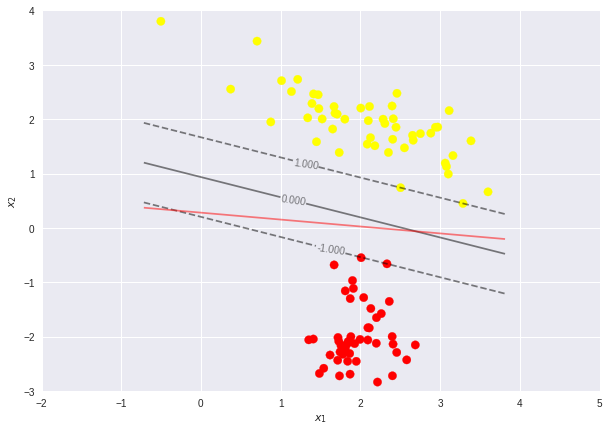

In [6]:
lin_sep_svm_demo(2)

### Неразделимый случай 

Будем допускать пропуск объектов за разделительную линию
* Вместо условия $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1$
* Будет условие $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i, \quad \xi_i \geq 0$

<center><img src='./images/slack.png'></center>

А целевой функционал заменим на 

$$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $$

Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi} \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i \quad i=1\dots n \\
   \xi_i \geq 0 \quad i=1\dots n
\end{cases}
$$


Условия Куна-Таккера, необходимые условия оптимума $\rightarrow$ получаем сопряженную задачу
$$\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle x_i, x_j \rangle)  \rightarrow \max\limits_\lambda  \\
0 \leq \lambda_i \leq C \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}$$

Заметим, что изначальный целевой функционал
$$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $$
Можно представить в виде
$$ \frac{1}{2С} ||w||^2 + \sum\limits_i(1-M_i)_+ \rightarrow \min\limits_{w,w_0}, $$
где $M_i$ - это отступ объекта  $x^{(i)}$

In [3]:
def lin_sep_svm_demo_C(class_sep=2, C=10):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)
    # x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

    lin_svm = SVC(kernel='linear', C=C).fit(X, y)
    
    log_reg = LogisticRegression(C=C).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_log_decision_function(lin_svm, log_reg)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

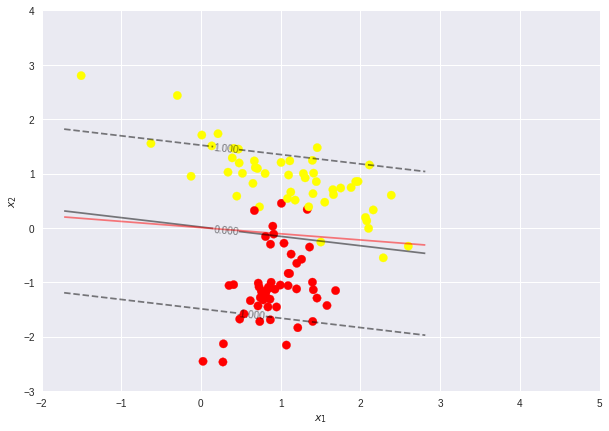

In [22]:
lin_sep_svm_demo_C(class_sep=1, C=0.01)

# Ядра и спрямляющие пространства

In [7]:
from sklearn.datasets.samples_generator import make_circles
from mpl_toolkits import mplot3d

def demo_nonlin_data():
    X, y = make_circles(n_samples=100, factor=0.1, 
                        noise=0.1, random_state=0)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    r = X[:, 0] ** 2 + X[:, 1] ** 2
    
    ax = fig.add_subplot(1, 2, 2)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
    ax.view_init(elev=30, azim=30)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_1^2 + x_2^2$')

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


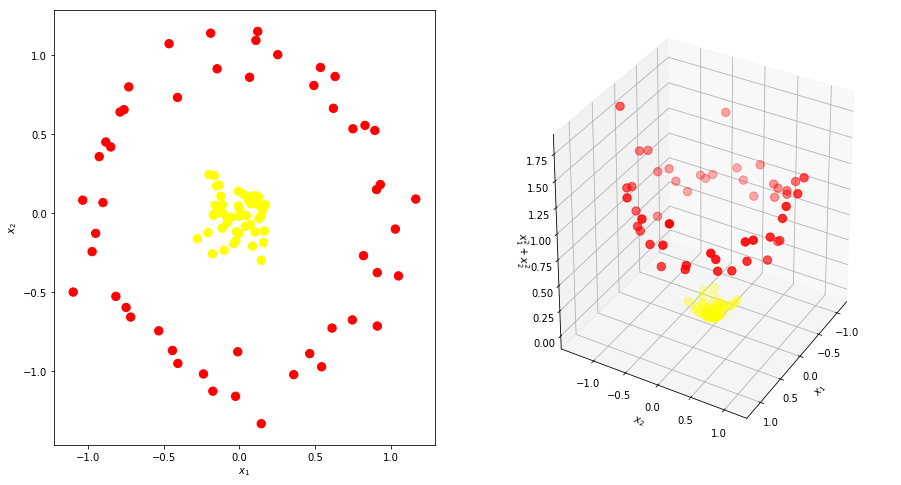

In [8]:
demo_nonlin_data() 

* $\psi: X \rightarrow H$
* $H$ - пространство большей размерности, в котором классы становятся линейноразделимыми называется **спрямляющим**.
* Разделяющся гиперплоскость в таком пространстве будет линейной, но при проекции на исходное пространство $X$ - нет

* Представим, что мы строим SVM в $H$
$$\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle \psi(x_i), \psi(x_j) \rangle)  \rightarrow \max\limits_\lambda  \\
0 \leq \lambda_i \leq C \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}$$
* Получается, нам не нужно в явном виде выражать преобразование $\psi$, нужно лишь знать результат скалярного произведения!
* Kernel trick!
* $k(x_i, x_j) = \langle \psi(x_i), \psi(x_j) \rangle$ - ядро

**Функция принятия решений:**
* Было $g(x) = w^\top x + w_0, \quad w = \sum\limits_{i:\lambda_i>0} \lambda_iy_ix_i$
* Получаем $g(x) = \sum\limits_{i:\lambda_i>0} \lambda_iy_i\langle x_i, x \rangle + w_0 = \sum\limits_{i:\lambda_i>0} \lambda_iy_i k(x_i, x) + w_0$

** Теорема Мерсера **<br/>
Функция $k(u, v)$ является ядром тогда и только тогда, когда она симметрична $k(u, v) = k(v, u)$, и неотрицательно определена, $ \int_X \int_X k(u,v) f(u)f(v) du dv \geq 0$,  $\forall f: X \rightarrow \mathbb{R}$

** Некоторые способы построения ядер **
1. Скалярное произведение - ядро, $k(u,v) = \langle u, v \rangle$
2. Константа - ядро, $k(u,v) = 1$
3. $\forall \phi: X \rightarrow \mathbb{R}$ произведение $k(u,v) =  \phi(u) \phi(v)$ - ядро
4. $k(u,v)  = \alpha_1k_1(u,v)  + \alpha_2k_2(u,v) $ - ядро
4. $k(u,v)  =  k_1(u,v) \cdot k_2(u,v) $ - ядро
5. $\forall \psi: X \rightarrow X \quad k(u,v) = k'(\psi(u),\psi(v)) $ - ядро

#### Связь ядра, нормы и расстояния
* $k(x,y)$ - ядро
* Норма $\|\psi(x)\|^2 = \langle \psi(x), \psi(x) \rangle = k(x,x)$
* Расстояние $\|\psi(x) - \psi(y)\|^2 = \langle \psi(x)-\psi(y), \psi(x)-\psi(y) \rangle = k(x,x) + k(y,y) - 2k(x,y)$

Наиболее популярны следующие ядра:

1. Линейное (linear): $$\langle x, y\rangle$$
2. Полиномиальное (polynomial): $$(\gamma \langle x, y\rangle + с)^d,$$ 
3. Radial basis function kernel (rbf): $$e^{(-\gamma  \cdot \|x - y\|^2)},$$ 
4. Sigmoid: $$\tanh(\gamma \langle x,y \rangle + r)$$ 

In [9]:
def lin_sep_svm_demo_kernel_C(class_sep=2, kernel='linear', C = 1, gamma=1.2, degree=2, coef0=0.0):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)
    # x_line = np.linspace(np.min(X) - 0.5, np.max(X) + 0.5)

    lin_svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=0.0).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(lin_svm)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

In [10]:
from IPython.display import YouTubeVideo

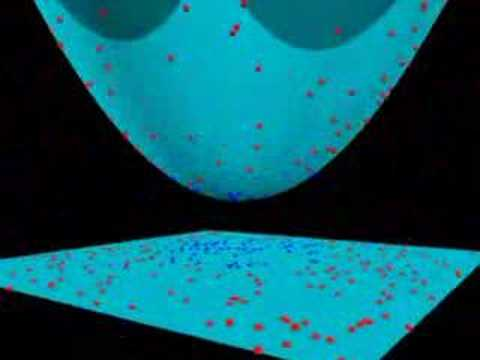

In [11]:
YouTubeVideo('3liCbRZPrZA', width=640, height=480)

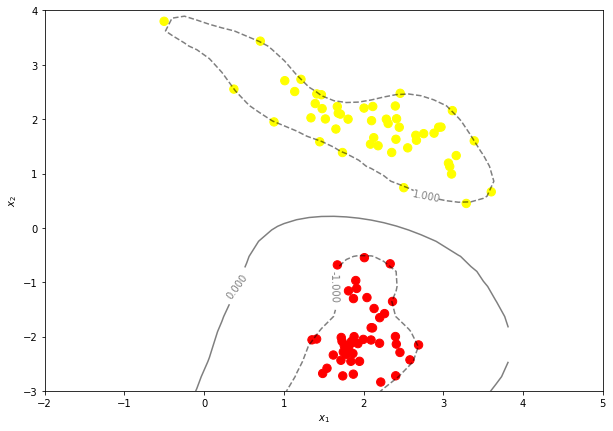

In [12]:
lin_sep_svm_demo_kernel_C(kernel=['rbf', 'linear', 'poly'][0])

# SVM для регрессии


<center><img src='images/regression.png' width=500></center>

# SVM для регрессии

Переменные $\xi_i \geq 0$, $\hat \xi_i \geq 0$ (slacks):
$$
y_i \leq g(x_i) + \epsilon + \xi_i
$$
$$
y_i \geq g(x_i) - \epsilon - \hat \xi_i
$$
Задача оптимизации

$$
\begin{cases} 
   C \sum_{i=1}^n (\hat \xi_i + \xi_i) + \frac{1}{2}\|w\|^2 \rightarrow \min\limits_{w, w_0} \\
   g(x_i) - y_i \leq \epsilon + \xi_i \\
   y_i - g(x_i) \leq \epsilon + \hat{\xi}_i 
\end{cases}
$$


<img src='regression.png'>

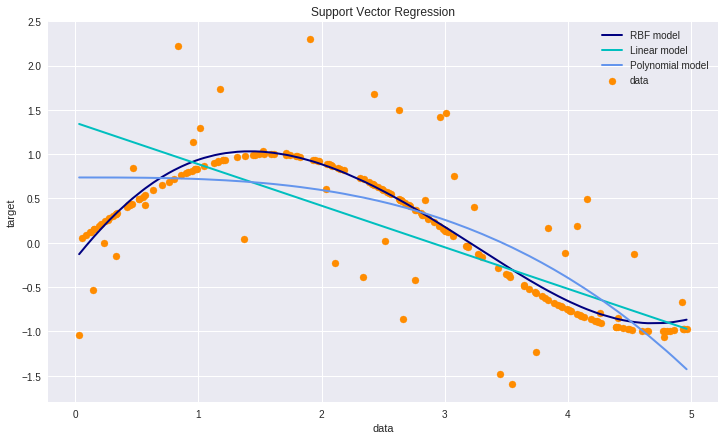

In [23]:
from sklearn.svm import SVR


X = np.sort(5 * np.random.rand(200, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(40))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=3)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

lw = 2
plt.figure(figsize=(12, 7))
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

# Titanic

In [13]:
df_train = pd.read_csv('train.csv')
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.46,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C


In [14]:
df_test = pd.read_csv('test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [15]:
# move target to the right
survived = df_train['Survived']
df_train.drop(labels=['Survived'], axis=1, inplace=True)
df_train['Survived'] = survived
df_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,0


In [16]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)
    

class FeaturesSum(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return np.sum(X, axis=1).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

class AgeFeature(BaseEstimator, TransformerMixin):
    # works with df only
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        # sex, name
        X['Initial'] = 0
        for i in X:
            X['Initial'] = X.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
        X['Initial'].replace(
            ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
            inplace=True
        )
        X.groupby('Initial')['Age'].mean() # lets check the average age by Initials

        ## Assigning the NaN Values with the Ceil values of the mean ages
        X.loc[(X.Age.isnull()) & (X.Initial=='Mr'), 'Age'] = 33
        X.loc[(X.Age.isnull()) & (X.Initial=='Mrs'), 'Age'] = 36
        X.loc[(X.Age.isnull()) & (X.Initial=='Master'), 'Age'] = 5
        X.loc[(X.Age.isnull()) & (X.Initial=='Miss'), 'Age'] = 22
        X.loc[(X.Age.isnull()) & (X.Initial=='Other'), 'Age'] = 46
        return X['Age'].as_matrix().reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [17]:
from sklearn.preprocessing import MinMaxScaler 

def get_sex_col(df):
    return df[['Sex']]

def get_age_name_cols(df):
    return df[['Age', 'Name']]

def get_pclass_col(df):
    return df[['Pclass']]

def get_sum_cols(df):
    return df[['Age', 'Fare']]

def get_num_cols(df):
    return df[['Fare', 'SibSp', 'Parch']]

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False),  OneHotEncoder(sparse=False), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly(), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), Imputer(strategy='mean'), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_age_name_cols, validate=False),  AgeFeature(), MinMaxScaler()),
])

In [18]:
x_train = vec.fit_transform(df_train)
x_train.shape

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

(891, 8)

In [19]:
y_train = df_train['Survived']
y_train.shape

(891,)

In [25]:
def randomized_cv(model, param_grid, x_train=x_train, y_train=y_train):
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=10)
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    return grid_search.best_estimator_

In [27]:
from sklearn.svm import SVC

param_grid = dict()
param_grid = {'kernel':('rbf', 'linear', 'poly'), 'gamma': [0.01, 0.1, 1, 10, 100], 'C': [0.01, 0.1, 1, 10]}

svc = SVC()
randomized_cv(svc, param_grid)

model SVC best accuracy score is 0.826038159371
time for training is 11.024780035 seconds


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
lr = LogisticRegressionCV(cv=10)
lr.fit(x_train, y_train)
lr

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [29]:
accuracy_score(y_train, lr.predict(x_train))

0.80022446689113358

In [32]:
import xgboost as xgb

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.025, 0.1, 0,5]
}
xgb = randomized_cv(xgb.XGBClassifier(), param_grid)

model XGBClassifier best accuracy score is 0.838383838384
time for training is 1.90973591805 seconds


<img src="svm_equations.png">

<img src="svm_plots.png">

## Метрики качества. Регрессия

$$
MSE = \frac 1 N \sum (h(\mathbf{x}_i) - y_i)^2, \;\; RMSE = \sqrt{MSE}
$$
* оценивает арифметическое среднее
* гладкая функция
* очень чувствительна к выбросам
* больше штраф на большие ошибки

$$
MAE =  \frac 1 N \sum |h(\mathbf{x}_i) - y_i|, \;\; RMAE = \sqrt{MAE}
$$

* оценивает медиану
* не гладкая
* более устойчива к выбросам
 
$$RMSLE $$
https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError

http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

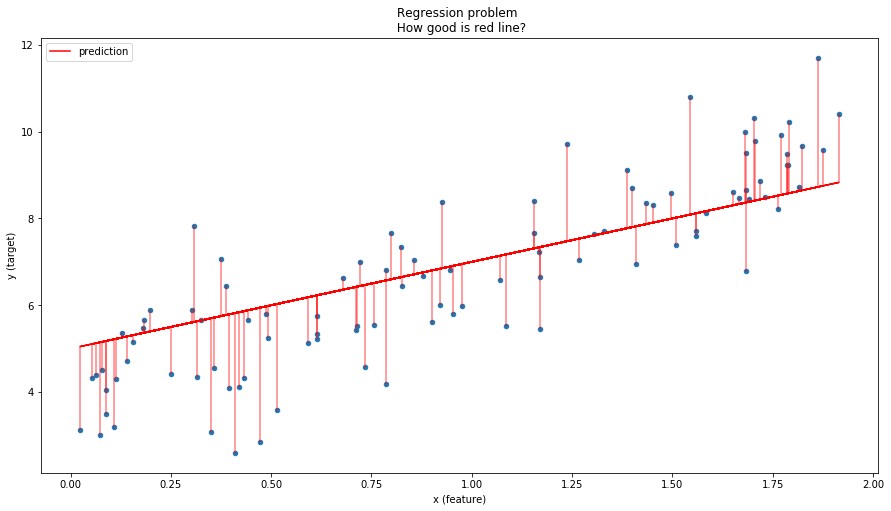

In [34]:
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100, 1)
df = pd.DataFrame(np.hstack([x, y]), columns=['x', 'y'])

def predict(x):
    return 2 * x + 5

y_pred = predict(x)

df.plot.scatter('x', 'y')
plt.title("Regression problem \n How good is red line?")
plt.xlabel("x (feature)")
plt.ylabel("y (target)")
plt.plot(x, y_pred, color='red', label='prediction')
plt.legend()

for x_i, y_i, y_i_pred in zip(x, y, y_pred):
    plt.plot([x_i, x_i], [y_i_pred, y_i], color='red', alpha=0.5)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_squared_error(y, y_pred))
print(mean_absolute_error(y, y_pred))

1.54102903368
0.979339650186


## Метрики качества. Функции решения.

<table>
<tr>
    <td></td>
    <td></td>
    <td>Предсказанный</td>
    <td></td>
</tr>
<tr>
    <td></td>
    <td></td>
    <td>true</td>
    <td>false</td>
</tr>
<tr>
    <td>Действительный</td>
    <td>true</td>
    <td>TP</td>
    <td>FN</td>
</tr>
<tr>
    <td></td>
    <td>false</td>
    <td>FP</td>
    <td>TN</td>
</tr>
</table>


$$
success\;rate = accuracy = \frac{TP + TN}{TP + FP + FN + TN}
$$
$$
recall = TPR = \frac{TP}{TP + FN};\;\;precision = \frac{TP}{TP + FP}
$$
$$
FPR = \frac{FP}{FP + TN}
$$
$$
affinity = lift = \frac{precision}{p}
$$


<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/440px-Precisionrecall.svg.png'>


## Receiver Operating Characteristic

$$
TPR = \frac{TP}{TP + FN};\;\;FPR = \frac{FP}{FP + TN}
$$

<img src="rocauc.png">


In [38]:
svc = SVC(probability=True)

In [39]:
svc.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
y_pred = svc.predict_proba(x_train)

In [41]:
y_pred

array([[ 0.82426582,  0.17573418],
       [ 0.20232402,  0.79767598],
       [ 0.24117649,  0.75882351],
       ..., 
       [ 0.30502983,  0.69497017],
       [ 0.8124224 ,  0.1875776 ],
       [ 0.81697838,  0.18302162]])

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [71]:
score = roc_auc_score(y_train, 1 - y_pred[:, 0])
print(score)

0.842733731718


In [72]:
tpr, fpr, _ = roc_curve(y_train, y_pred[:, 0])
auc_ = auc(fpr, tpr)

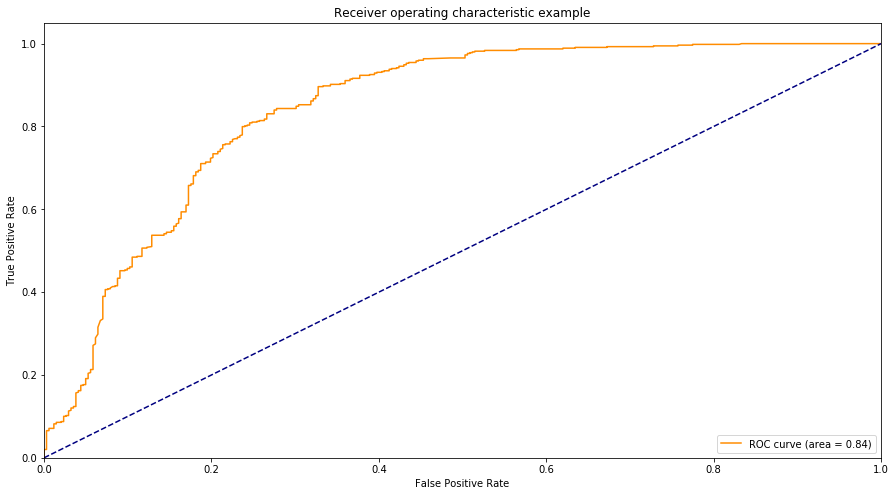

In [73]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Задача
1. Выпишите формулу F-меры. Почему метрика качества~$\min(\text{precision}(a, X), \text{recall}(a, X))$ считается не очень хорошим способом объединения точности и полноты?
2. Пусть даны выборка~$X$, состоящая из 8 объектов, и классификатор~$a(x)$, предсказывающий оценку принадлежности объекта положительному классу. Предсказания~$a(x)$ и реальные метки объектов приведены ниже:
$$
\begin{align*}
            &a(x_1) = 0.1, \quad  y_1 = +1,\\
            &a(x_2) = 0.8, \quad y_2 = +1,\\
            &a(x_3) = 0.2, \quad y_3 = -1,\\
            &a(x_4) = 0.25, \quad y_4 = -1,\\
            &a(x_5) = 0.9, \quad y_5 = +1,\\
        \end{align*}
       $$
    Постройте ROC-кривую и вычислите AUC-ROC


https://sadanand-singh.github.io/posts/svmpython/  
https://www.quantstart.com/articles/Support-Vector-Machines-A-Guide-for-Beginners  
https://youtu.be/3liCbRZPrZA  
http://datascientist.one/support-vector-machines/  